In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [4]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [5]:
# Error voxels
indice_beginning_0_all = np.where(scan_100206_long[:, 0] == 0)[0]

In [6]:
mask_100206_long_pro = np.copy(mask_100206_long)
mask_100206_long_pro[indice_beginning_0_all] = 0

In [7]:
scan_100206_long_no_background = process_data.remove_background(scan_100206_long, mask_100206_long_pro)

In [8]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [9]:
S0_100206 = process_data.get_S0(scan_100206_long_no_background, bvals_all_100206*1e-3)

In [10]:
normalized_scan_100206_full = scan_100206_long_no_background / S0_100206

In [11]:
normalized_scan_100206_full.shape

(935442, 288)

In [40]:
rand_7g_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 7))

In [41]:
rand_7g_bval_indice_100206

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
       252, 253, 254, 255, 272, 273, 274, 275, 276, 277, 278, 279, 280,
       281, 282, 283, 284, 285, 286, 287])

In [42]:
bvals_100206_7g = bvals_all_100206[rand_7g_bval_indice_100206]*1e-3

In [43]:
normalized_scan_100206_7g = normalized_scan_100206_full[:, rand_7g_bval_indice_100206]

In [44]:
big_b_indice_100206_7g = np.where(bvals_100206_7g != 0.005)[0]

In [45]:
big_b_indice_100206_7g

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110])

In [46]:
bvals_100206_7g_no_b5 = bvals_100206_7g[big_b_indice_100206_7g]

In [47]:
normalized_scan_100206_7g_no_b5 = normalized_scan_100206_7g[:, big_b_indice_100206_7g]

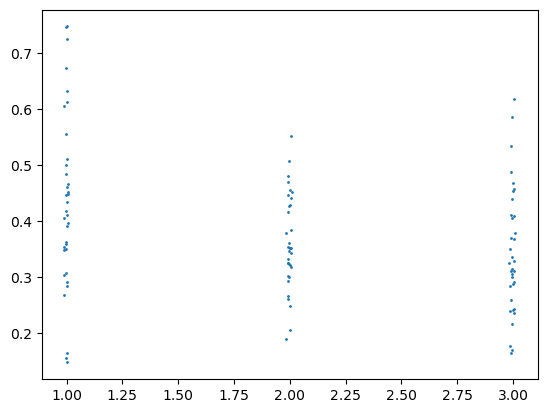

In [48]:
plt.plot(bvals_100206_7g_no_b5, normalized_scan_100206_7g_no_b5[42,:], "o", markersize = 1)

ANN

In [24]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [25]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [26]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [49]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')
n_100206_7g = n_100206_all[:, rand_7g_bval_indice_100206]

In [50]:
print(n_100206_7g.shape)
print(big_b_indice_100206_7g)

(3, 111)
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110]


In [51]:
n_100206_7g_no_b5 = n_100206_7g[:,big_b_indice_100206_7g].T
print(n_100206_7g_no_b5.shape)

b_values_100206_7g_no_b5 = torch.FloatTensor(bvals_100206_7g_no_b5)
gradient_directions_100206_7g_no_b5 = torch.FloatTensor(n_100206_7g_no_b5)

net = BallStickNet(gradient_directions_100206_7g_no_b5, b_values_100206_7g_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

(104, 3)


In [52]:
batch_size = 128
num_batches = len(normalized_scan_100206_7g_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_7g_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [ ]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 315.45it/s]


Loss: 533.7115026349202
Average Loss: 0.07303113062875208
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 307.16it/s]


Loss: 424.556660215836
Average Loss: 0.05809478109138424
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.84it/s]


Loss: 422.15687550930306
Average Loss: 0.05776640332639615
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.90it/s]


Loss: 421.2481543906033
Average Loss: 0.05764205725104041
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.98it/s]


Loss: 420.42372845159844
Average Loss: 0.05752924581986842
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.35it/s]


Loss: 419.6779088503681
Average Loss: 0.05742719059255174
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.16it/s]


Loss: 419.3909662319347
Average Loss: 0.05738792641378417
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.46it/s]


Loss: 419.33261548914015
Average Loss: 0.057379941911486064
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.33it/s]


Loss: 418.9961980492808
Average Loss: 0.057333907779047726
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.42it/s]


Loss: 418.2227516588755
Average Loss: 0.05722807220291126
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|███                                                                                                                                                           | 144/7308 [00:02<00:45, 156.57it/s]

X_batch: 
torch.Size([128, 104])
tensor([[0.2086, 0.0959, 0.0871,  ..., 0.1442, 0.0960, 0.0803],
        [0.5792, 0.2468, 0.2166,  ..., 0.4740, 0.2305, 0.3345],
        [0.6053, 0.2910, 0.1498,  ..., 0.3947, 0.2330, 0.1478],
        ...,
        [0.5161, 0.1389, 0.2196,  ..., 0.5354, 0.3644, 0.0856],
        [0.5963, 0.1885, 0.2551,  ..., 0.5462, 0.3274, 0.1118],
        [0.0605, 0.0376, 0.0393,  ..., 0.0718, 0.0391, 0.0337]])
X_pred: 
torch.Size([128, 104])
tensor([[0.1756, 0.0917, 0.0685,  ..., 0.1694, 0.0947, 0.0754],
        [0.4590, 0.3099, 0.2237,  ..., 0.4438, 0.3178, 0.2484],
        [0.4783, 0.2597, 0.1506,  ..., 0.4695, 0.2640, 0.1591],
        ...,
        [0.4691, 0.2742, 0.1772,  ..., 0.4555, 0.2816, 0.1888],
        [0.5438, 0.3063, 0.1735,  ..., 0.5386, 0.3084, 0.1778],
        [0.0763, 0.0294, 0.0222,  ..., 0.0739, 0.0304, 0.0245]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.44it/s]


Loss: 418.4886212502606
Average Loss: 0.057264452825706164
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.37it/s]


Loss: 418.1821906240657
Average Loss: 0.057222521979209864
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.98it/s]


Loss: 418.46334760892205
Average Loss: 0.057260994473032574
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.26it/s]


Loss: 418.2870635751169
Average Loss: 0.0572368724103882
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.19it/s]


Loss: 417.86154307983816
Average Loss: 0.05717864574163084
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.25it/s]


Loss: 418.0580590283498
Average Loss: 0.05720553626551037
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.89it/s]


Loss: 416.6477664001286
Average Loss: 0.05701255697867113
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.05it/s]


Loss: 417.2929960680194
Average Loss: 0.0571008478472933
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.11it/s]


Loss: 417.142203947762
Average Loss: 0.05708021400489355
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.46it/s]


Loss: 416.75549973361194
Average Loss: 0.05702729881412315
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.11it/s]


Loss: 416.6719730934128
Average Loss: 0.057015869334074
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.30it/s]


Loss: 416.3957110566553
Average Loss: 0.0569780666470519
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.93it/s]


Loss: 416.6392640667036
Average Loss: 0.05701139355045205
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.88it/s]


Loss: 416.55460810428485
Average Loss: 0.05699980953807948
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.70it/s]


Loss: 416.49126698775217
Average Loss: 0.05699114217128519
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.81it/s]


Loss: 415.9468592694029
Average Loss: 0.05691664740960631
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.40it/s]


Loss: 415.99927213275805
Average Loss: 0.0569238193941924
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.68it/s]


Loss: 415.76688235765323
Average Loss: 0.056892020027046145
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.03it/s]


Loss: 415.68916099285707
Average Loss: 0.05688138491965751
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.35it/s]


Loss: 415.3737894159276
Average Loss: 0.0568382306261532
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.67it/s]


Loss: 415.3981511844322
Average Loss: 0.05684156420148224
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.13it/s]


Loss: 415.2009180029854
Average Loss: 0.05681457553407025
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.35it/s]


Loss: 414.37300776480697
Average Loss: 0.056701287324138885
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.91it/s]


Loss: 414.1391828833148
Average Loss: 0.05666929158228172
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.99it/s]


Loss: 414.1244491408579
Average Loss: 0.056667275470834416
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.07it/s]


Loss: 413.7872087911237
Average Loss: 0.05662112873441758
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.75it/s]


Loss: 413.52447495865636
Average Loss: 0.05658517719740782
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.17it/s]


Loss: 413.5541796972975
Average Loss: 0.056589241885235016
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.71it/s]


Loss: 412.7033993739169
Average Loss: 0.05647282421646373
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.89it/s]


Loss: 412.7354970895685
Average Loss: 0.05647721635051567
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.00it/s]


Loss: 412.9355647931807
Average Loss: 0.056504592883576996
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.74it/s]


Loss: 412.3046409476083
Average Loss: 0.05641825957137497
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.26it/s]


Loss: 412.1044542223681
Average Loss: 0.056390866751829236
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.23it/s]


Loss: 411.8416286141146
Average Loss: 0.05635490265655646
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.79it/s]


Loss: 412.2053706799634
Average Loss: 0.056404675790909055
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.64it/s]


Loss: 411.83959500235505
Average Loss: 0.05635462438455871
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.33it/s]


Loss: 411.5760657864157
Average Loss: 0.05631856401018277
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.51it/s]


Loss: 411.32494930247776
Average Loss: 0.056284202148669644
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.85it/s]


Loss: 411.0989162349142
Average Loss: 0.05625327261014152
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.82it/s]


Loss: 411.0793350492604
Average Loss: 0.0562505931922907
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.23it/s]


Loss: 410.7156639506575
Average Loss: 0.056200829768836544
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.56it/s]


Loss: 410.2101884984877
Average Loss: 0.0561316623561149
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.25it/s]


Loss: 409.98226963658817
Average Loss: 0.056100474772384806
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.82it/s]


Loss: 409.91676572477445
Average Loss: 0.05609151145659202
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 292.23it/s]


Loss: 409.27373414486647
Average Loss: 0.05600352136629262
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.40it/s]


Loss: 409.0925039933063
Average Loss: 0.05597872249497897
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.39it/s]


Loss: 409.18207574496046
Average Loss: 0.055990979165977076
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.29it/s]


Loss: 408.91748707788065
Average Loss: 0.055954773820180714
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.06it/s]


Loss: 408.49148556776345
Average Loss: 0.05589648133111158
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.91it/s]


Loss: 408.26215316541493
Average Loss: 0.055865100323674734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.05it/s]


Loss: 408.7214591274969
Average Loss: 0.05592795007218075
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.61it/s]


Loss: 408.2196858993266
Average Loss: 0.05585928925825487
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.64it/s]


Loss: 407.7208184474148
Average Loss: 0.05579102606012791
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.52it/s]


Loss: 407.5115970396437
Average Loss: 0.05576239696765786
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.81it/s]


Loss: 407.53644442535006
Average Loss: 0.055765796993069244
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.37it/s]


Loss: 407.18493174761534
Average Loss: 0.05571769728347227
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.98it/s]


Loss: 407.1557091786526
Average Loss: 0.055713698573980924
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.74it/s]


Loss: 406.8800258114934
Average Loss: 0.055675975069990884
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.42it/s]


Loss: 407.23162888898514
Average Loss: 0.05572408714956009
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.82it/s]


Loss: 406.53808225668035
Average Loss: 0.05562918476418724
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.64it/s]


Loss: 406.50451817386784
Average Loss: 0.05562459197781443
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.29it/s]


Loss: 406.55273041292094
Average Loss: 0.05563118916432963
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.61it/s]


Loss: 406.2534508872777
Average Loss: 0.0555902368482865
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.39it/s]


Loss: 406.25611544121057
Average Loss: 0.055590601456104345
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.51it/s]


Loss: 406.1237217094749
Average Loss: 0.05557248518192049
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.94it/s]


Loss: 405.925332844723
Average Loss: 0.05554533837503051
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.21it/s]


Loss: 405.99116694158874
Average Loss: 0.05555434687213858
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.40it/s]


Loss: 405.903666585451
Average Loss: 0.05554237364332936
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.32it/s]


Loss: 405.56458494625986
Average Loss: 0.05549597495159549
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.47it/s]


Loss: 405.6727079281118
Average Loss: 0.055510770105105606
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.65it/s]


Loss: 405.50073254923336
Average Loss: 0.0554872376230478
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.83it/s]


Loss: 405.19081511185504
Average Loss: 0.055444829654057885
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.18it/s]


Loss: 405.446510175243
Average Loss: 0.05547981803164245
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.56it/s]


Loss: 405.0251219011843
Average Loss: 0.055422156800928345
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.33it/s]


Loss: 405.2513408062514
Average Loss: 0.055453111768780976
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.04it/s]


Loss: 404.87065426050685
Average Loss: 0.05540102001375299
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.36it/s]


Loss: 405.03572831419297
Average Loss: 0.05542360814370457
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.32it/s]


Loss: 404.7673680433072
Average Loss: 0.05538688670543339
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.96it/s]


Loss: 404.67511111707427
Average Loss: 0.055374262604963635
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.15it/s]


Loss: 404.50362721970305
Average Loss: 0.05535079737543829
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.88it/s]


Loss: 404.50054242275655
Average Loss: 0.05535037526310298
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.57it/s]


Loss: 404.4237679017242
Average Loss: 0.055339869718353064
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.22it/s]


Loss: 404.3118710212875
Average Loss: 0.055324558158358995
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.05it/s]


Loss: 404.24627522961237
Average Loss: 0.0553155822700619
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.97it/s]


Loss: 404.2490791908931
Average Loss: 0.055315965953871525
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.79it/s]


Loss: 404.5155572074
Average Loss: 0.05535242983133552
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.44it/s]


Loss: 404.086380896857
Average Loss: 0.05529370291418405
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.78it/s]


Loss: 404.05079779052176
Average Loss: 0.05528883385201447
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.71it/s]


Loss: 404.08870000834577
Average Loss: 0.05529402025292088
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.74it/s]


Loss: 403.8736409514677
Average Loss: 0.05526459235789104
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.14it/s]


Loss: 403.7281393285375
Average Loss: 0.05524468244780207
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.50it/s]


Loss: 403.5963416900486
Average Loss: 0.05522664774083861
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.11it/s]


Loss: 403.8593991175294
Average Loss: 0.05526264355740687
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.57it/s]


Loss: 403.82172000571154
Average Loss: 0.05525748768551061
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.36it/s]


Loss: 403.69253566488624
Average Loss: 0.05523981057264453
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.62it/s]


Loss: 403.41510828444734
Average Loss: 0.05520184842425388
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.91it/s]


Loss: 403.56716009415686
Average Loss: 0.0552226546379525
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.04it/s]


Loss: 403.6187415206805
Average Loss: 0.05522971285176252
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.17it/s]


Loss: 403.31063527520746
Average Loss: 0.05518755271965072
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.73it/s]


Loss: 403.2516089521814
Average Loss: 0.05517947577342384
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.53it/s]


Loss: 403.26183067285456
Average Loss: 0.05518087447630741
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.66it/s]


Loss: 403.3094129853416
Average Loss: 0.055187385465974494
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.29it/s]


Loss: 403.32080981647596
Average Loss: 0.05518894496667706
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.98it/s]


Loss: 403.2566646456253
Average Loss: 0.05518016757602973
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.43it/s]


Loss: 403.3024792941287
Average Loss: 0.05518643668502035
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.46it/s]


Loss: 402.91055955551565
Average Loss: 0.055132807820951785
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.99it/s]


Loss: 403.0169481919147
Average Loss: 0.05514736565297136
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.02it/s]


Loss: 403.2048662195448
Average Loss: 0.055173079668793756
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.53it/s]


Loss: 402.91874609934166
Average Loss: 0.05513392803767675
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.74it/s]


Loss: 402.94472420960665
Average Loss: 0.055137482787302496
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.07it/s]


Loss: 403.0105999931693
Average Loss: 0.05514649698866575
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.88it/s]


Loss: 402.9848482438829
Average Loss: 0.05514297321344867
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.49it/s]


Loss: 402.918035967974
Average Loss: 0.05513383086589682
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.20it/s]


Loss: 402.8441832845565
Average Loss: 0.05512372513472311
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.34it/s]


Loss: 402.66510832239874
Average Loss: 0.05509922117164734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.44it/s]


Loss: 402.70059629692696
Average Loss: 0.05510407721632826
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.57it/s]


Loss: 402.79790775082074
Average Loss: 0.055117392959882425
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.73it/s]


Loss: 402.63507973984815
Average Loss: 0.05509511217020363
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.61it/s]


Loss: 402.5726678359788
Average Loss: 0.05508657195347274
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.20it/s]


Loss: 402.4786937041208
Average Loss: 0.05507371287686382
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.92it/s]


Loss: 402.5050076970365
Average Loss: 0.055077313587443416
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.32it/s]


Loss: 402.6309422389604
Average Loss: 0.05509454600970996
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.92it/s]


Loss: 402.5843692270573
Average Loss: 0.055088173129044515
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.18it/s]


Loss: 402.59076560032554
Average Loss: 0.05508904838537569
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.21it/s]


Loss: 402.4118020811584
Average Loss: 0.055064559671751286
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.26it/s]


Loss: 402.4553073197603
Average Loss: 0.0550705127695348
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.39it/s]


Loss: 402.34508060174994
Average Loss: 0.05505542974846058
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.88it/s]


Loss: 402.2524295344483
Average Loss: 0.05504275171516808
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.14it/s]


Loss: 402.52264445787296
Average Loss: 0.05507972693731157
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.63it/s]


Loss: 402.13471810356714
Average Loss: 0.05502664451335073
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.96it/s]


Loss: 402.17827394558117
Average Loss: 0.05503260453552014
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.12it/s]


Loss: 402.26931889913976
Average Loss: 0.055045062794080425
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.86it/s]


Loss: 402.3139827409759
Average Loss: 0.05505117443089435
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.34it/s]


Loss: 402.25783718633465
Average Loss: 0.05504349167848038
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.85it/s]


Loss: 402.09562599030323
Average Loss: 0.0550212952915029
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.96it/s]


Loss: 402.13776254141703
Average Loss: 0.05502706110309483
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.89it/s]


Loss: 402.25443757954054
Average Loss: 0.05504302648871655
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.31it/s]


Loss: 402.0663919886574
Average Loss: 0.05501729501760501
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.99it/s]


Loss: 402.00216101529077
Average Loss: 0.05500850588605511
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.31it/s]


Loss: 402.04599893302657
Average Loss: 0.05501450450643494
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.66it/s]


Loss: 402.03311349009164
Average Loss: 0.05501274130953635
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.14it/s]


Loss: 402.1186420689337
Average Loss: 0.05502444472754977
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.37it/s]


Loss: 402.0639556264505
Average Loss: 0.0550169616347086
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.96it/s]


Loss: 401.9109760976862
Average Loss: 0.054996028475326524
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.42it/s]


Loss: 402.02188289002515
Average Loss: 0.055011204555285326
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.59it/s]


Loss: 401.91734646470286
Average Loss: 0.05499690017305731
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.48it/s]


Loss: 401.9088733019307
Average Loss: 0.05499574073644372
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.99it/s]


Loss: 401.949643881293
Average Loss: 0.05500131963345553
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.68it/s]


Loss: 401.93836786900647
Average Loss: 0.05499977666516235
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.68it/s]


Loss: 401.90114344190806
Average Loss: 0.054994683010660655
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.43it/s]


Loss: 401.81680282531306
Average Loss: 0.05498314214905762
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.42it/s]


Loss: 401.81781292450614
Average Loss: 0.054983280367338
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.97it/s]


Loss: 401.8136304006912
Average Loss: 0.05498270804607159
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.34it/s]


Loss: 401.81724425219
Average Loss: 0.05498320255229748
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.34it/s]


Loss: 401.7234999402426
Average Loss: 0.05497037492340485
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.61it/s]


Loss: 401.8513785735704
Average Loss: 0.05498787336803098
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.25it/s]


Loss: 401.7017452879809
Average Loss: 0.054967398096330174
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.12it/s]


Loss: 401.7441803335678
Average Loss: 0.05497320475281442
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.61it/s]


Loss: 401.73088595061563
Average Loss: 0.054971385598059065
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.09it/s]


Loss: 401.716559672961
Average Loss: 0.0549694252426055
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.50it/s]


Loss: 401.66136593790725
Average Loss: 0.05496187273370378
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.55it/s]


Loss: 401.7549525350332
Average Loss: 0.0549746787814769
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.78it/s]


Loss: 401.5861459313892
Average Loss: 0.054951579903036285
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.54it/s]


Loss: 401.5942452289164
Average Loss: 0.05495268818129672
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.90it/s]


Loss: 401.6516633387655
Average Loss: 0.05496054506551252
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 243.75it/s]


Loss: 401.67867779242806
Average Loss: 0.05496424162457965
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.41it/s]


Loss: 401.4855859335512
Average Loss: 0.05493781964060635
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.64it/s]


Loss: 401.55045052291825
Average Loss: 0.05494669547385307
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.14it/s]


Loss: 401.58258147421293
Average Loss: 0.05495109215574889
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.26it/s]


Loss: 401.6120032421313
Average Loss: 0.05495511812289701
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.77it/s]


Loss: 401.4886686208192
Average Loss: 0.054938241464260976
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.55it/s]


Loss: 401.45194639940746
Average Loss: 0.054933216529749244
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.08it/s]


Loss: 401.4374142643064
Average Loss: 0.054931228005515385
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.91it/s]


Loss: 401.63627501763403
Average Loss: 0.054958439383912705
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.56it/s]


Loss: 401.3768611114938
Average Loss: 0.054922942133483005
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.82it/s]


Loss: 401.5089156110771
Average Loss: 0.05494101198837946
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.91it/s]


Loss: 401.4404651836958
Average Loss: 0.054931645482169646
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.87it/s]


Loss: 401.33330431277864
Average Loss: 0.05491698198040211
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.28it/s]


Loss: 401.4483697374817
Average Loss: 0.054932727112408555
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.92it/s]


Loss: 401.4027338747401
Average Loss: 0.054926482467807895
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.26it/s]


Loss: 401.39670124067925
Average Loss: 0.05492565698421993
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.24it/s]


Loss: 401.32409807271324
Average Loss: 0.05491572223217204
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.11it/s]


Loss: 401.5268244158942
Average Loss: 0.05494346256375126
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.11it/s]


Loss: 401.2434840181377
Average Loss: 0.05490469129969043
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.60it/s]


Loss: 401.31806942611
Average Loss: 0.05491489729421319
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.25it/s]


Loss: 401.35577420075424
Average Loss: 0.05492005667771678
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.63it/s]


Loss: 401.3072269500699
Average Loss: 0.05491341364943485
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.52it/s]


Loss: 401.38959427154623
Average Loss: 0.054924684492548746
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.93it/s]


Loss: 401.1546728061512
Average Loss: 0.054892538698159715
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.93it/s]


Loss: 401.1811906513758
Average Loss: 0.05489616730314392
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.70it/s]


Loss: 401.2928333422169
Average Loss: 0.05491144408076312
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.12it/s]


Loss: 401.3683977650944
Average Loss: 0.05492178404010597
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.83it/s]


Loss: 401.28858533105813
Average Loss: 0.05491086279844802
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.69it/s]


Loss: 401.20054683694616
Average Loss: 0.05489881593280599
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.62it/s]


Loss: 401.3048054240644
Average Loss: 0.05491308229667
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.16it/s]


Loss: 401.25906294747256
Average Loss: 0.05490682306341989
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.59it/s]


Loss: 401.15168306278065
Average Loss: 0.05489212959260819
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.18it/s]


Loss: 401.11876451806165
Average Loss: 0.05488762513930783
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.71it/s]


Loss: 401.22290372964926
Average Loss: 0.05490187516826071
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.50it/s]


Loss: 401.19523391034454
Average Loss: 0.0548980889313553
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.88it/s]


Loss: 401.2011350975372
Average Loss: 0.05489889642823443
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.97it/s]


Loss: 401.338746201247
Average Loss: 0.05491772662852312
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.66it/s]


Loss: 401.108767171856
Average Loss: 0.05488625713900602
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.65it/s]


Loss: 401.2414519661106
Average Loss: 0.054904413241120775
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.57it/s]


Loss: 401.05632731853984
Average Loss: 0.05487908146121235
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.96it/s]


Loss: 401.3486886434257
Average Loss: 0.05491908711595864
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.88it/s]


Loss: 401.0607821100857
Average Loss: 0.054879691038599576
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.98it/s]


Loss: 401.17695805151016
Average Loss: 0.054895588129653825
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.40it/s]


Loss: 401.02997086010873
Average Loss: 0.054875474939806886
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.01it/s]


Loss: 401.0538168163039
Average Loss: 0.05487873793326545
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.06it/s]


Loss: 401.0721148038283
Average Loss: 0.05488124176297596
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.62it/s]


Loss: 401.1054478371516
Average Loss: 0.054885802933381446
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.11it/s]


Loss: 400.99346710089594
Average Loss: 0.054870479898863705
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.89it/s]


Loss: 401.0294045689516
Average Loss: 0.054875397450595456
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.18it/s]


Loss: 401.0602677038405
Average Loss: 0.05487962064912979
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.48it/s]


Loss: 401.0773000200279
Average Loss: 0.054881951289002175
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.63it/s]


Loss: 401.1113030707929
Average Loss: 0.05488660414214463
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.37it/s]


Loss: 400.8857487575151
Average Loss: 0.0548557401146025
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.02it/s]


Loss: 400.9612993574701
Average Loss: 0.05486607818246718
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.51it/s]


Loss: 400.9941733817104
Average Loss: 0.054870576543748
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.82it/s]


Loss: 400.8767527185846
Average Loss: 0.054854509129527176
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.31it/s]


Loss: 401.0363634438254
Average Loss: 0.054876349677589684
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.12it/s]


Loss: 400.9460318291094
Average Loss: 0.05486398902970846
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.85it/s]


Loss: 400.98531806934625
Average Loss: 0.05486936481518148
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.00it/s]


Loss: 400.9721424591262
Average Loss: 0.05486756191285252
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.87it/s]


Loss: 400.90091836755164
Average Loss: 0.05485781586857576
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.50it/s]


Loss: 400.84351490205154
Average Loss: 0.054849960988239126
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.18it/s]


Loss: 400.86992587777786
Average Loss: 0.05485357496959194
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.75it/s]


Loss: 400.9276029409375
Average Loss: 0.05486146728803195
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.15it/s]


Loss: 400.9466514450032
Average Loss: 0.05486407381568189
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.41it/s]


Loss: 400.9274423420429
Average Loss: 0.05486144531226641
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.76it/s]


Loss: 400.8346583319362
Average Loss: 0.05484874908756653
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.21it/s]


Loss: 400.7766497929115
Average Loss: 0.0548408114111811
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.72it/s]


Loss: 400.8021398719866
Average Loss: 0.0548442993804032
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.72it/s]


Loss: 400.8254423502367
Average Loss: 0.05484748800632686
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.89it/s]


Loss: 400.789093648782
Average Loss: 0.05484251418292036
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.70it/s]


Loss: 400.92898241220973
Average Loss: 0.05486165604983713
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.37it/s]


Loss: 400.85430597444065
Average Loss: 0.05485143759912981
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.83it/s]


Loss: 400.8494095057249
Average Loss: 0.05485076758425354
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.85it/s]


Loss: 400.90528979781084
Average Loss: 0.05485841403910931
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.66it/s]


Loss: 400.74092429247685
Average Loss: 0.054835922864323594
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.95it/s]


Loss: 400.71528587467037
Average Loss: 0.054832414596971864
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.45it/s]


Loss: 400.732799801277
Average Loss: 0.05483481113865312
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.09it/s]


Loss: 400.7182728149928
Average Loss: 0.05483282331896453
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.49it/s]


Loss: 400.7459719120525
Average Loss: 0.05483661356213088
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.11it/s]


Loss: 400.8230522121303
Average Loss: 0.05484716094856736
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.49it/s]


Loss: 400.73774373717606
Average Loss: 0.0548354876487652
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.52it/s]


Loss: 400.6975093402434
Average Loss: 0.054829982120996636
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.39it/s]


Loss: 400.7721544210799
Average Loss: 0.05484019628093595
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.73it/s]


Loss: 400.76962581579573
Average Loss: 0.054839850275834115
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.11it/s]


Loss: 400.6937527146656
Average Loss: 0.05482946807808779
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.55it/s]


Loss: 400.72531435033306
Average Loss: 0.05483378685691476
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.79it/s]


Loss: 400.7395760815125
Average Loss: 0.054835738380064655
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.05it/s]


Loss: 400.62980508059263
Average Loss: 0.05482071771765088
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.92it/s]


Loss: 400.69514446076937
Average Loss: 0.054829658519536036
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.23it/s]


Loss: 400.7066930956207
Average Loss: 0.054831238792504206
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.94it/s]


Loss: 400.73161335173063
Average Loss: 0.05483464878923517
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.61it/s]


Loss: 400.7452455777675
Average Loss: 0.054836514173202996
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.29it/s]


Loss: 400.6493416589219
Average Loss: 0.05482339103159851
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.31it/s]


Loss: 400.62548918346874
Average Loss: 0.05482012714606852
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.82it/s]


Loss: 400.5918309709523
Average Loss: 0.054815521479331185
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.31it/s]


Loss: 400.5951216612011
Average Loss: 0.05481597176535319
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.98it/s]


Loss: 400.60402316972613
Average Loss: 0.05481718981523346
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.01it/s]


Loss: 400.63770643342286
Average Loss: 0.054821798909882716
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.35it/s]


Loss: 400.64283558214083
Average Loss: 0.054822500763839745
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.95it/s]


Loss: 400.68612843821757
Average Loss: 0.05482842479997504
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.01it/s]


Loss: 400.6413296025712
Average Loss: 0.0548222946911017
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.73it/s]


Loss: 400.57959906570613
Average Loss: 0.05481384771014041
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.48it/s]


Loss: 400.6865995414555
Average Loss: 0.054828489264019634
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.90it/s]


Loss: 400.58068484114483
Average Loss: 0.05481399628368156
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.51it/s]


Loss: 400.56120795034803
Average Loss: 0.05481133113715764
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.07it/s]


Loss: 400.65737215429544
Average Loss: 0.05482448989522379
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.89it/s]


Loss: 400.62778292922303
Average Loss: 0.05482044101385099
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.71it/s]


Loss: 400.65398511034437
Average Loss: 0.05482402642451346
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.78it/s]


Loss: 400.5181008949876
Average Loss: 0.05480543252531302
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.12it/s]


Loss: 400.5683770442847
Average Loss: 0.054812312129759816
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.21it/s]


Loss: 400.74103655060753
Average Loss: 0.05483593822531575
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.06it/s]


Loss: 400.5591809093021
Average Loss: 0.05481105376427232
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.42it/s]


Loss: 400.50893117603846
Average Loss: 0.05480417777449897
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.74it/s]


Loss: 400.5459937385749
Average Loss: 0.054809249280045824
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.00it/s]


Loss: 400.53342008264735
Average Loss: 0.05480752874694134
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.53it/s]


Loss: 400.5438149035908
Average Loss: 0.054808951136233006
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.48it/s]


Loss: 400.5057897765655
Average Loss: 0.054803747916880884
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.19it/s]


Loss: 400.54464575252496
Average Loss: 0.05480906482656335
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.60it/s]


Loss: 400.58461016765796
Average Loss: 0.05481453341100957
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.82it/s]


Loss: 400.6320252942387
Average Loss: 0.05482102152356851
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.82it/s]


Loss: 400.5355314356275
Average Loss: 0.05480781765676348
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.41it/s]


Loss: 400.5988593781367
Average Loss: 0.05481648322087256
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.05it/s]


Loss: 400.4353627227247
Average Loss: 0.05479411093633343
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.77it/s]


Loss: 400.5442451725248
Average Loss: 0.05480901001266076
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.26it/s]


Loss: 400.5560888554901
Average Loss: 0.05481063065893406
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.12it/s]


Loss: 400.54056839295663
Average Loss: 0.05480850689558794
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.68it/s]


Loss: 400.60490378993563
Average Loss: 0.05481731031608315
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.74it/s]


Loss: 400.5146377638448
Average Loss: 0.05480495864310958
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.92it/s]


Loss: 400.4290441791527
Average Loss: 0.05479324632993332
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.63it/s]


Loss: 400.54733270709403
Average Loss: 0.05480943249960236
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.07it/s]


Loss: 400.4170502824709
Average Loss: 0.05479160512896427
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.85it/s]


Loss: 400.6657748934813
Average Loss: 0.05482563969533132
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.66it/s]


Loss: 400.44195731636137
Average Loss: 0.05479501331641508
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.84it/s]


Loss: 400.53825816931203
Average Loss: 0.0548081907730312
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.83it/s]


Loss: 400.4418215523474
Average Loss: 0.05479499473896379
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.93it/s]


Loss: 400.3981642606668
Average Loss: 0.054789020834792944
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.19it/s]


Loss: 400.3860484343022
Average Loss: 0.05478736294941191
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.93it/s]


Loss: 400.5048614672851
Average Loss: 0.0548036208904331
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.31it/s]


Loss: 400.3641747892834
Average Loss: 0.05478436983980343
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.54it/s]


Loss: 400.33747835597023
Average Loss: 0.05478071679747814
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.32it/s]


Loss: 400.3550029506441
Average Loss: 0.054783114798938715
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.10it/s]


Loss: 400.37644308176823
Average Loss: 0.05478604858809089
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.02it/s]


Loss: 400.4631370580755
Average Loss: 0.05479791147483245
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.36it/s]


Loss: 400.49867564439774
Average Loss: 0.054802774445046214
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.52it/s]


Loss: 400.30604214710183
Average Loss: 0.05477641518159576
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.58it/s]


Loss: 400.3227083804086
Average Loss: 0.05477869572802526
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.96it/s]


Loss: 400.35409867647104
Average Loss: 0.05478299106136714
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.73it/s]


Loss: 400.404284567805
Average Loss: 0.05478985831524425
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.90it/s]


Loss: 400.28415537881665
Average Loss: 0.054773420276247486
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.87it/s]


Loss: 400.3157921512611
Average Loss: 0.0547777493365163
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.93it/s]


Loss: 400.4114148863591
Average Loss: 0.05479083400196485
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.21it/s]


Loss: 400.3378546368331
Average Loss: 0.054780768286375625
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.74it/s]


Loss: 400.39170855493285
Average Loss: 0.05478813745962409
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.79it/s]


Loss: 400.4892063795123
Average Loss: 0.054801478705461454
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.31it/s]


Loss: 400.28825903637335
Average Loss: 0.05477398180574348
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.33it/s]


Loss: 400.37613121559843
Average Loss: 0.05478600591346448
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.75it/s]


Loss: 400.3080190133769
Average Loss: 0.05477668568874889
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.93it/s]


Loss: 400.2595646562986
Average Loss: 0.05477005537168837
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.59it/s]


Loss: 400.324027315015
Average Loss: 0.05477887620621442
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.57it/s]


Loss: 400.3213397692889
Average Loss: 0.054778508452283645
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.56it/s]


Loss: 400.2614106745459
Average Loss: 0.054770307974075796
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.37it/s]


Loss: 400.3514159221668
Average Loss: 0.05478262396307701
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.83it/s]


Loss: 400.35237900400534
Average Loss: 0.054782755747674515
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.68it/s]


Loss: 400.3357680027839
Average Loss: 0.054780482759001624
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.21it/s]


Loss: 400.2862088365946
Average Loss: 0.05477370126390183
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.46it/s]


Loss: 400.2596640943084
Average Loss: 0.05477006897842206
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.52it/s]


Loss: 400.22584136761725
Average Loss: 0.054765440800166564
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.60it/s]


Loss: 400.2230341746472
Average Loss: 0.054765056674144386
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.44it/s]


Loss: 400.36693388340063
Average Loss: 0.05478474738415444
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.12it/s]


Loss: 400.21005801297724
Average Loss: 0.05476328106362579
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.49it/s]


Loss: 400.2296376435552
Average Loss: 0.05476596026868571
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.16it/s]


Loss: 400.3063819180243
Average Loss: 0.054776461674606494
-----------------------------------------------------------------
Epoch: 348; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.60it/s]


Loss: 400.2432222326752
Average Loss: 0.05476781913419201
-----------------------------------------------------------------
Epoch: 349; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.14it/s]


Loss: 400.229566691909
Average Loss: 0.05476595055992187
-----------------------------------------------------------------
Epoch: 350; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.27it/s]


Loss: 400.27017033006996
Average Loss: 0.05477150661331007
-----------------------------------------------------------------
Epoch: 351; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.60it/s]


Loss: 400.3493275754154
Average Loss: 0.0547823382013431
-----------------------------------------------------------------
Epoch: 352; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.79it/s]


Loss: 400.18082413915545
Average Loss: 0.05475928080721886
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 353; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.51it/s]


Loss: 400.2396201931406
Average Loss: 0.05476732624427211
-----------------------------------------------------------------
Epoch: 354; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.15it/s]


Loss: 400.2853357787244
Average Loss: 0.054773581797855006
-----------------------------------------------------------------
Epoch: 355; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.34it/s]


Loss: 400.265844094567
Average Loss: 0.05477091462706171
-----------------------------------------------------------------
Epoch: 356; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.45it/s]


Loss: 400.27986635942943
Average Loss: 0.054772833382516345
-----------------------------------------------------------------
Epoch: 357; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.58it/s]


Loss: 400.29897397663444
Average Loss: 0.05477544799899212
-----------------------------------------------------------------
Epoch: 358; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.23it/s]


Loss: 400.2108380671125
Average Loss: 0.054763387803381566
-----------------------------------------------------------------
Epoch: 359; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.39it/s]


Loss: 400.1875924137421
Average Loss: 0.054760206953166676
-----------------------------------------------------------------
Epoch: 360; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.56it/s]


Loss: 400.1785477246158
Average Loss: 0.05475896931097644
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 361; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.68it/s]


Loss: 400.25742476340383
Average Loss: 0.054769762556568666
-----------------------------------------------------------------
Epoch: 362; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.43it/s]


Loss: 400.1384127927013
Average Loss: 0.054753477393637284
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 363; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.62it/s]


Loss: 400.15127958729863
Average Loss: 0.05475523803876555
-----------------------------------------------------------------
Epoch: 364; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.13it/s]


Loss: 400.13603048212826
Average Loss: 0.05475315140696884
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 365; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.37it/s]


Loss: 400.1343473107554
Average Loss: 0.0547529210879523
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 366; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.01it/s]


Loss: 400.1769964816049
Average Loss: 0.05475875704455458
-----------------------------------------------------------------
Epoch: 367; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.50it/s]


Loss: 400.1724176504649
Average Loss: 0.054758130494042816
-----------------------------------------------------------------
Epoch: 368; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.06it/s]


Loss: 400.1469752904959
Average Loss: 0.054754649054528724
-----------------------------------------------------------------
Epoch: 369; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.09it/s]


Loss: 400.187317880569
Average Loss: 0.05476016938705104
-----------------------------------------------------------------
Epoch: 370; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.16it/s]


Loss: 400.1430545952171
Average Loss: 0.05475411256092188
-----------------------------------------------------------------
Epoch: 371; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.13it/s]


Loss: 400.12464049016126
Average Loss: 0.05475159284211292
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 372; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.89it/s]


Loss: 400.2046782998368
Average Loss: 0.05476254492334932
-----------------------------------------------------------------
Epoch: 373; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.14it/s]


Loss: 400.216638637241
Average Loss: 0.05476418153218952
-----------------------------------------------------------------
Epoch: 374; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.57it/s]


Loss: 400.1027932204306
Average Loss: 0.05474860334160244
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 375; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.39it/s]


Loss: 400.22336535016075
Average Loss: 0.0547651019909908
-----------------------------------------------------------------
Epoch: 376; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.16it/s]


Loss: 400.1985181015916
Average Loss: 0.054761701984344775
-----------------------------------------------------------------
Epoch: 377; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.93it/s]


Loss: 400.1146946218796
Average Loss: 0.05475023188586201
-----------------------------------------------------------------
Epoch: 378; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.83it/s]


Loss: 400.0896237457637
Average Loss: 0.05474680127884013
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 379; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.24it/s]


Loss: 400.1056119715795
Average Loss: 0.05474898904920354
-----------------------------------------------------------------
Epoch: 380; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.21it/s]


Loss: 400.34350249613635
Average Loss: 0.054781541118792604
-----------------------------------------------------------------
Epoch: 381; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.85it/s]


Loss: 400.1998839885928
Average Loss: 0.05476188888732796
-----------------------------------------------------------------
Epoch: 382; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.29it/s]


Loss: 400.10839062486775
Average Loss: 0.05474936926996001
-----------------------------------------------------------------
Epoch: 383; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.90it/s]


Loss: 400.0863047724124
Average Loss: 0.0547463471226618
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 384; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.57it/s]


Loss: 400.1600188552402
Average Loss: 0.054756433888237574
-----------------------------------------------------------------
Epoch: 385; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.00it/s]


Loss: 400.1806670296937
Average Loss: 0.054759259308934556
-----------------------------------------------------------------
Epoch: 386; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.01it/s]


Loss: 400.19320970820263
Average Loss: 0.05476097560320233
-----------------------------------------------------------------
Epoch: 387; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.25it/s]


Loss: 400.0391935124062
Average Loss: 0.0547399005900939
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 388; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.29it/s]


Loss: 400.0996058762539
Average Loss: 0.05474816719707908
-----------------------------------------------------------------
Epoch: 389; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.44it/s]


Loss: 400.22023631003685
Average Loss: 0.05476467382458085
-----------------------------------------------------------------
Epoch: 390; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.24it/s]


Loss: 400.05639236047864
Average Loss: 0.054742254017580545
-----------------------------------------------------------------
Epoch: 391; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.40it/s]


Loss: 400.15384834539145
Average Loss: 0.054755589538230905
-----------------------------------------------------------------
Epoch: 392; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.78it/s]


Loss: 400.1173403186258
Average Loss: 0.05475059391333139
-----------------------------------------------------------------
Epoch: 393; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.26it/s]


Loss: 400.2568679305259
Average Loss: 0.054769686361593586
-----------------------------------------------------------------
Epoch: 394; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.64it/s]


Loss: 400.09037574077956
Average Loss: 0.05474690417908861
-----------------------------------------------------------------
Epoch: 395; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.50it/s]


Loss: 400.13475432572886
Average Loss: 0.05475297678239311
-----------------------------------------------------------------
Epoch: 396; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.22it/s]


Loss: 400.1203312026337
Average Loss: 0.05475100317496356
-----------------------------------------------------------------
Epoch: 397; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.72it/s]


Loss: 400.03403208358213
Average Loss: 0.05473919431904518
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 398; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.61it/s]


Loss: 400.1758610128891
Average Loss: 0.054758601671167084
-----------------------------------------------------------------
Epoch: 399; Bad epochs: 1


  8%|█████████████                                                                                                                                                 | 607/7308 [00:04<00:22, 295.32it/s]

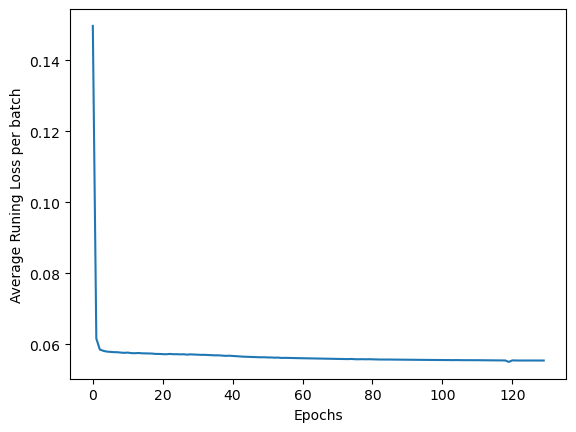

In [36]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [37]:
torch.save(final_model, 'model_100206_7g_02.pt')